In [4]:
#CELL 1

#Establish Mouse Dictionary (with eventlogs for future reference) 

import numpy as np
import scipy.ndimage as nd
from scipy.io import loadmat, matlab
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pickle as p
#import functions.data_io as dataio
#import functions.plot as plot
import os
import re

directory = '/Users/rishachakraborty/Downloads'
mouseList = ['AS_opto_F1', 'AS_opto_F2', 'AS_opto_F4', 'AS_opto_F6']
CSPlusIndex = np.array([15, 15, 15, 16])
CSMinusIndex = np.array([16, 16, 16, 15])
# 15: CS1 = CS+, CS2 = CS-, 16: CS2 = CS+, CS1 = CS-
ExpIndex = np.array([0, 0, 1, 1])
# 0: control, 1: experimental
ReacquisitionDay = np.array([10, 10, 11, 10])


mouseDict = {}

for iM in range(len(mouseList)):
    inanal = np.concatenate((np.arange(1,7+1),np.arange(ReacquisitionDay[iM]-1,ReacquisitionDay[iM]+2)),axis=0)
    fs, days = findfiles(directory,'.mat',mouseList[iM],inanal.tolist())
    mouseDict[mouseList[iM]] = {}
    for iF in [x for x,y in zip(fs,inanal) if y]:
        mouseDict[mouseList[iM]][str(iF)] = {}
        matdata = load_mat(iF)
        eventlog = matdata['eventlog']
        mouseDict[mouseList[iM]][str(iF)] = eventlog


/var/folders/kn/fwnw3jp94k7f92srh58xkgxr0000gn/T/ipykernel_3979/3181014971.py:61: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], matlab.mio5_params.mat_struct):
/var/folders/kn/fwnw3jp94k7f92srh58xkgxr0000gn/T/ipykernel_3979/3181014971.py:90: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(sub_elem, matlab.mio5_params.mat_struct):
/var/folders/kn/fwnw3jp94k7f92srh58xkgxr0000gn/T/ipykernel_3979/3181014971.py:74: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, matlab.mio5_params.mat_struct):


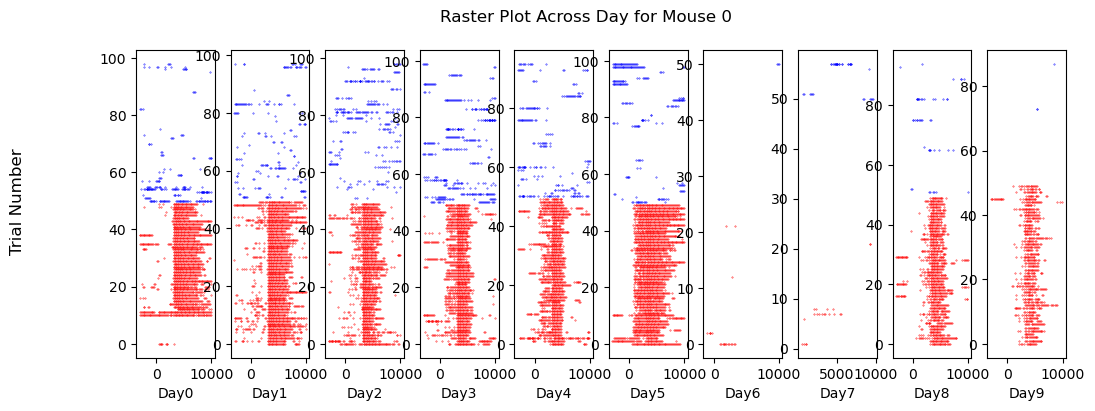

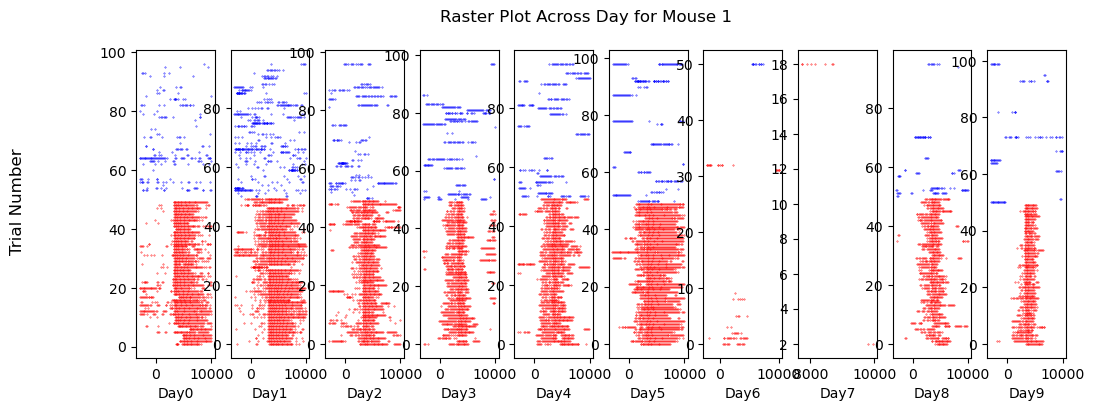

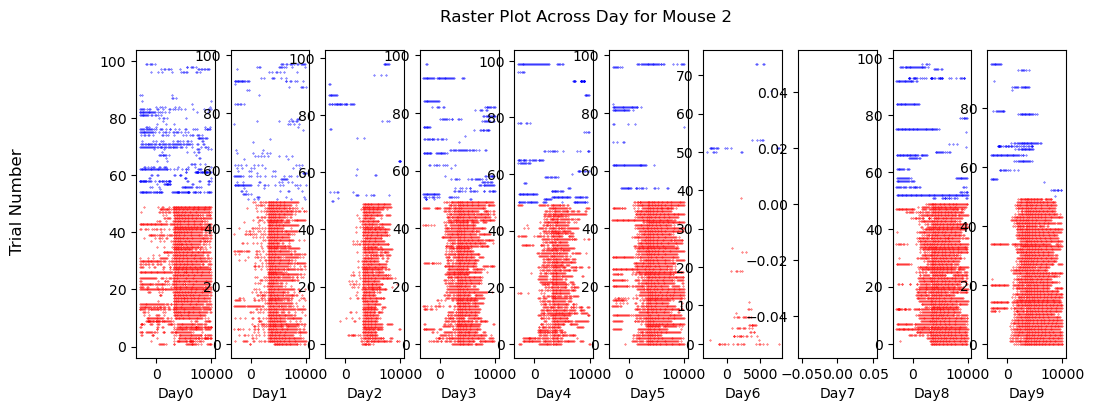

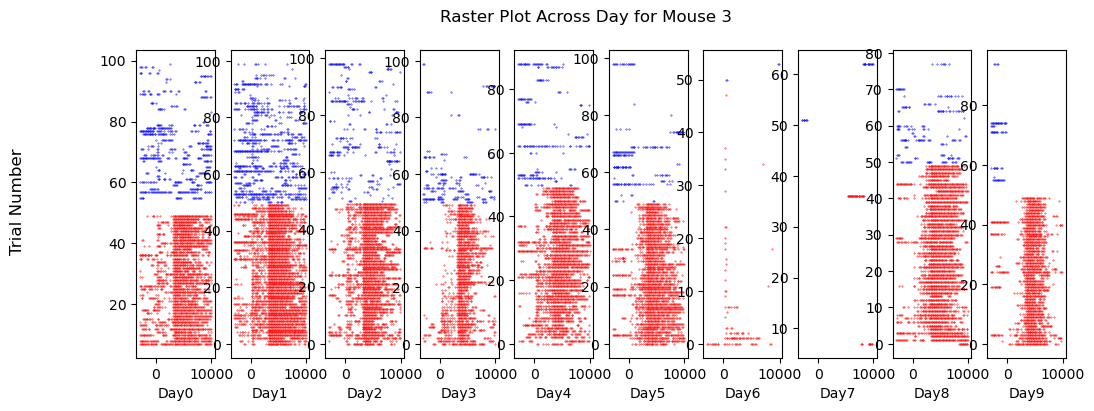

In [8]:
#CELL 1 continue

##Establish MouseData Array (CS+ and CS- separated into trials and time bins)
#Produce RasterPlot

mouseDataCSPlus = np.zeros(shape = (len(mouseList),10,50,130))
mouseDataCSMinus = np.zeros(shape = (len(mouseList),10,50,130))

#second dimension = days --> 6 days of acquisition, 2 days of training, 2 days of reacquisition  
#third dimension = 50 CS+ and 50 CS- trials
#fourth dimension = 130 100ms bins from 3 seconds before cue to 10 seconds after cue for each trial
        
        
for i,iM in enumerate(mouseDict):
    fig, axs = plt.subplots(1, len(mouseDict[iM]), figsize=(12,4))
    for j,iF in enumerate(mouseDict[iM]):
        eventlog = mouseDict[mouseList[i]][str(iF)]
        eventidx = eventlog[:,0]
        eventtime = eventlog[:,1]
        CSPlus_times = eventtime[eventidx == CSPlusIndex[i]]
        CSMinus_times = eventtime[eventidx == CSMinusIndex[i]]
        lick_times = eventtime[eventidx == 5]
        for n in range(len(CSPlus_times)):
            bins = np.transpose(range(-3000+CSPlus_times[n],10100+CSPlus_times[n],100))
            licks = lick_times[np.logical_and(lick_times >= CSPlus_times[n] - 3000, lick_times <= CSPlus_times[n] + 10000)]
            axs[j].scatter(licks-CSPlus_times[n],np.ones(len(licks))*n,s=0.1,color = 'red')
            licktimesextracted, bin_edges = np.histogram(licks,bins)
            mouseDataCSPlus[i,j,n,:] = licktimesextracted
        for n in range(len(CSMinus_times)):
            bins = np.transpose(range(-3000+CSMinus_times[n],10100+CSMinus_times[n],100))
            licks = lick_times[np.logical_and(lick_times >= CSMinus_times[n] - 3000, lick_times <= CSMinus_times[n] + 10000)]
            axs[j].scatter(licks-CSMinus_times[n],np.ones(len(licks))*(n+50),s=0.1,color = 'blue')
            licktimesextracted, bin_edges = np.histogram(licks, bins)
            mouseDataCSMinus[i,j,n,:] = licktimesextracted
        axs[j].set(xlabel = 'Day' + str(j))
        fig.suptitle('Raster Plot Across Day for Mouse ' + str(i))
        fig.supylabel("Trial Number")
            

In [9]:
#CELL 2

#Get Trial-Averaged Baseline and Cue-->Reward CS+ and CS- licks for each Mouse

baselineCSPlus = np.zeros(shape = (np.size(mouseDataCSPlus,0),np.size(mouseDataCSPlus,1)))
baselineCSMinus = np.zeros(shape = (np.size(mouseDataCSMinus,0),np.size(mouseDataCSMinus,1)))
aftercueCSPlus = np.zeros(shape = (np.size(mouseDataCSPlus,0),np.size(mouseDataCSPlus,1)))
aftercueCSMinus = np.zeros(shape = (np.size(mouseDataCSMinus,0),np.size(mouseDataCSMinus,1)))
CSplusacrosstrials = np.zeros(shape = (np.size(mouseDataCSPlus,0),np.size(mouseDataCSPlus,1),130))
CSminusacrosstrials = np.zeros(shape = (np.size(mouseDataCSMinus,0),np.size(mouseDataCSMinus,1),130))
CSplusbaselinesubtractedacrosstrials = np.zeros(shape = (np.size(mouseDataCSPlus,0),np.size(mouseDataCSPlus,1),50))
CSminusbaselinesubtractedacrosstrials = np.zeros(shape = (np.size(mouseDataCSMinus,0),np.size(mouseDataCSMinus,1),50))

for iM in range(np.size(mouseDataCSPlus,0)):
    for iF in range(np.size(mouseDataCSPlus,1)):
        baselineCSPlus[iM,iF] = np.mean(np.sum(mouseDataCSPlus[iM,iF,:,0:29],axis=1),axis=0)
        aftercueCSPlus[iM,iF] = np.mean(np.sum(mouseDataCSPlus[iM,iF,:,30:59],axis=1),axis=0)
        CSplusacrosstrials[iM,iF,:] = np.mean(mouseDataCSPlus[iM,iF,:,:],axis=0)*10
        CSplusbaselinesubtractedacrosstrials[iM,iF,:] = np.sum(mouseDataCSPlus[iM,iF,:,30:59],axis=1) - np.sum(mouseDataCSPlus[iM,iF,:,0:29],axis=1)
        
for iM in range(np.size(mouseDataCSMinus,0)):
    for iF in range(np.size(mouseDataCSMinus,1)):
        baselineCSMinus[iM,iF] = np.mean(np.sum(mouseDataCSMinus[iM,iF,:,0:29],axis=1),axis=0)
        aftercueCSMinus[iM,iF] = np.mean(np.sum(mouseDataCSMinus[iM,iF,:,30:59],axis=1),axis=0)
        CSminusacrosstrials[iM,iF,:] = np.mean(mouseDataCSMinus[iM,iF,:,:],axis=0)*10
        CSminusbaselinesubtractedacrosstrials[iM,iF,:] = np.sum(mouseDataCSMinus[iM,iF,:,30:59],axis=1) - np.sum(mouseDataCSMinus[iM,iF,:,0:29],axis=1)

baselinesubtractedCSPlus = aftercueCSPlus - baselineCSPlus
baselinesubtractedCSMinus = aftercueCSMinus - baselineCSMinus

diffplotNOTbaselinesubtracted = aftercueCSPlus - aftercueCSMinus
diffplotbaselinesubtracted = baselinesubtractedCSPlus - baselinesubtractedCSMinus




In [10]:
#CELL 3

#Get Trial-Averaged CS+ and CS- Lick Rates (Baseline subtracted and not-baseline subtracted)
#for Control vs Experimental Animals

#Run CELL 2 prior to running this cell

import math

controlNOTbaselinesubCSPlusavg = np.mean(aftercueCSPlus[np.where(ExpIndex ==0),:], axis = 1)
controlbaselinesubCSPlusavg = np.mean(baselinesubtractedCSPlus[np.where(ExpIndex ==0),:], axis = 1)
expNOTbaselinesubCSPlusavg = np.mean(aftercueCSPlus[np.where(ExpIndex ==1),:], axis = 1)
expbaselinesubCSPlusavg = np.mean(baselinesubtractedCSPlus[np.where(ExpIndex ==1),:], axis = 1)
controlNOTbaselinesubCSPlussem = np.std(aftercueCSPlus[np.where(ExpIndex ==0),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==0)))
controlbaselinesubCSPlussem = np.std(baselinesubtractedCSPlus[np.where(ExpIndex ==0),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==0)))
expNOTbaselinesubCSPlussem = np.std(aftercueCSPlus[np.where(ExpIndex ==1),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==1)))
expbaselinesubCSPlussem = np.std(baselinesubtractedCSPlus[np.where(ExpIndex ==1),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==1)))

controlNOTbaselinesubCSMinusavg = np.mean(aftercueCSMinus[np.where(ExpIndex ==0),:], axis = 1)
controlbaselinesubCSMinusavg = np.mean(baselinesubtractedCSMinus[np.where(ExpIndex ==0),:], axis = 1)
expNOTbaselinesubCSMinusavg = np.mean(aftercueCSMinus[np.where(ExpIndex ==1),:], axis = 1)
expbaselinesubCSMinusavg = np.mean(baselinesubtractedCSMinus[np.where(ExpIndex ==1),:], axis = 1)
controlNOTbaselinesubCSMinussem = np.std(aftercueCSMinus[np.where(ExpIndex ==0),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==0)))
controlbaselinesubCSMinussem = np.std(baselinesubtractedCSMinus[np.where(ExpIndex ==0),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==0)))
expNOTbaselinesubCSMinussem = np.std(aftercueCSMinus[np.where(ExpIndex ==1),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==1)))
expbaselinesubCSMinussem = np.std(baselinesubtractedCSMinus[np.where(ExpIndex ==1),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==1)))

controldiffplotNOTbaselinesubtractedavg = np.mean(diffplotNOTbaselinesubtracted[np.where(ExpIndex ==0),:], axis = 1)
controldiffplotbaselinesubtractedavg = np.mean(diffplotbaselinesubtracted[np.where(ExpIndex ==0),:], axis = 1)
expdiffplotNOTbaselinesubtractedavg = np.mean(diffplotNOTbaselinesubtracted[np.where(ExpIndex ==1),:], axis = 1)
expdiffplotbaselinesubtractedavg = np.mean(diffplotbaselinesubtracted[np.where(ExpIndex ==1),:], axis = 1)
controldiffplotNOTbaselinesubtractedsem = np.std(diffplotNOTbaselinesubtracted[np.where(ExpIndex ==0),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==0)))
controldiffplotbaselinesubtractedsem = np.std(diffplotbaselinesubtracted[np.where(ExpIndex ==0),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==0)))
expdiffplotNOTbaselinesubtractedsem = np.std(diffplotNOTbaselinesubtracted[np.where(ExpIndex ==1),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==1)))
expdiffplotbaselinesubtractedsem = np.std(diffplotbaselinesubtracted[np.where(ExpIndex ==1),:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==1)))

controlCSplusacrosstrialsavg = np.mean(CSplusacrosstrials[np.where(ExpIndex == 0),:,:], axis = 1)
controlCSplusacrosstrialssem = np.std(CSplusacrosstrials[np.where(ExpIndex == 0),:,:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==0)))
expCSplusacrosstrialsavg = np.mean(CSplusacrosstrials[np.where(ExpIndex == 1),:,:], axis = 1)
expCSplusacrosstrialssem = np.std(CSplusacrosstrials[np.where(ExpIndex == 1),:,:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==1)))
controlCSminusacrosstrialsavg = np.mean(CSminusacrosstrials[np.where(ExpIndex == 0),:,:], axis = 1)
controlCSminusacrosstrialssem = np.std(CSminusacrosstrials[np.where(ExpIndex == 0),:,:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==0)))
expCSminusacrosstrialsavg = np.mean(CSminusacrosstrials[np.where(ExpIndex == 1),:,:], axis = 1)
expCSminusacrosstrialssem = np.std(CSminusacrosstrials[np.where(ExpIndex == 1),:,:], axis = 1)/math.sqrt(np.size(np.where(ExpIndex ==1)))





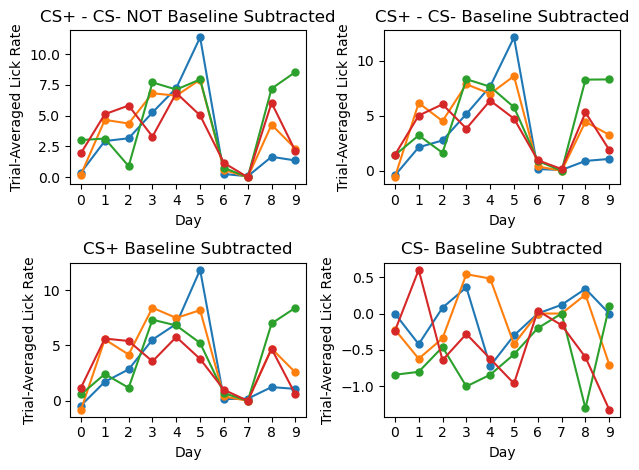

In [29]:
#CELL 4

#Plot Trial-Averaged Baseline and Cue-->Reward CS+ and CS- licks for each Mouse on one Figure

#Run CELL 2 prior to running this cell

fig, axs = plt.subplots(2, 2)

#First subplot: CSPlus - CSMinus Not Baseline Subtracted
#Second subplot: CSPlus - CSMinus Baseline Subtracted
#Third subplot: CSplus baseline subtracted
#Fourth subplot: CSMinus baseline subtracted


for iM in range(np.size(mouseDataCSPlus,0)):
    axs[0,0].plot(range(np.size(diffplotNOTbaselinesubtracted,1)), diffplotNOTbaselinesubtracted[iM,:],label = str(iM), marker=".", markersize=10)
    axs[0,1].plot(range(np.size(diffplotbaselinesubtracted,1)), diffplotbaselinesubtracted[iM,:],label = str(iM), marker=".", markersize=10)
    axs[1,0].plot(range(np.size(baselinesubtractedCSPlus,1)),baselinesubtractedCSPlus[iM,:],label = str(iM), marker=".", markersize=10)
    axs[1,1].plot(range(np.size(baselinesubtractedCSMinus,1)),baselinesubtractedCSMinus[iM,:],label = str(iM), marker=".", markersize=10)
    
    
axs[0,0].set_title('CS+ - CS- NOT Baseline Subtracted')
axs[0,1].set_title('CS+ - CS- Baseline Subtracted')
axs[1,0].set_title('CS+ Baseline Subtracted')
axs[1,1].set_title('CS- Baseline Subtracted')
    
for ax in axs.flat:
    ax.set(xlabel='Day', ylabel='Trial-Averaged Lick Rate')
    ax.set_xticks(ticks = range(np.size(mouseDataCSPlus,1)))
    
fig.tight_layout()


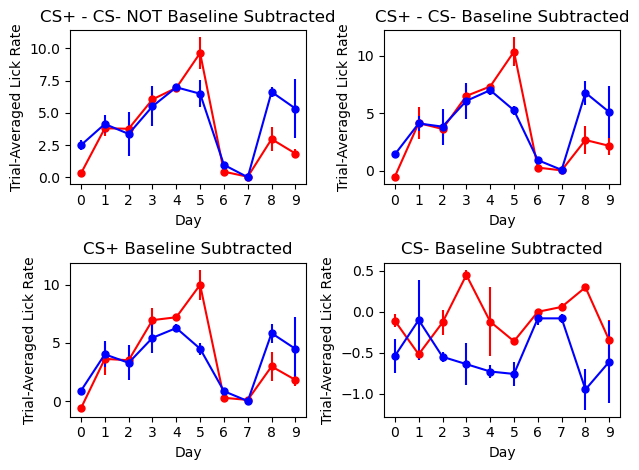

In [28]:
#CELL 5

#Plot Trial-Averaged CS+ and CS- Lick Rates (Baseline subtracted and not-baseline subtracted)
#for Control vs Experimental Animals

#Run CELL 2,3 prior to running this cell

fig, axs = plt.subplots(2, 2)
#First subplot: CSPlus - CSMinus Not Baseline Subtracted
#Second subplot: CSPlus - CSMinus Baseline Subtracted
#Third subplot: CSplus baseline subtracted
#Fourth subplot: CSMinus baseline subtracted

axs[0,0].errorbar(np.transpose(range(np.size(controldiffplotNOTbaselinesubtractedavg))),controldiffplotNOTbaselinesubtractedavg[0], yerr = controldiffplotNOTbaselinesubtractedsem[0], color = "red", marker=".", markersize=10, markerfacecolor = "red", label = "Control")
axs[0,0].errorbar(np.transpose(range(np.size(expdiffplotNOTbaselinesubtractedavg))),expdiffplotNOTbaselinesubtractedavg[0], yerr = expdiffplotNOTbaselinesubtractedsem[0], color = "blue", marker=".", markersize=10, markerfacecolor = "blue", label = "Experimental")

axs[0,1].errorbar(np.transpose(range(np.size(controldiffplotbaselinesubtractedavg))),controldiffplotbaselinesubtractedavg[0], yerr = controldiffplotbaselinesubtractedsem[0], color = "red", marker=".", markersize=10, markerfacecolor = "red", label = "Control")
axs[0,1].errorbar(np.transpose(range(np.size(expdiffplotbaselinesubtractedavg))),expdiffplotbaselinesubtractedavg[0], yerr = expdiffplotbaselinesubtractedsem[0], color = "blue", marker=".", markersize=10, markerfacecolor = "blue", label = "Experimental")

axs[1,0].errorbar(np.transpose(range(np.size(controlbaselinesubCSPlusavg))),controlbaselinesubCSPlusavg[0], yerr = controlbaselinesubCSPlussem[0], color = "red", marker=".", markersize=10, markerfacecolor = "red", label = "Control")
axs[1,0].errorbar(np.transpose(range(np.size(expbaselinesubCSPlusavg))),expbaselinesubCSPlusavg[0], yerr = expbaselinesubCSPlussem[0], color = "blue", marker=".", markersize=10, markerfacecolor = "blue", label = "Experimental")

axs[1,1].errorbar(np.transpose(range(np.size(controlbaselinesubCSMinusavg))),controlbaselinesubCSMinusavg[0], yerr = controlbaselinesubCSMinussem[0], color = "red", marker=".", markersize=10, markerfacecolor = "red", label = "Control")
axs[1,1].errorbar(np.transpose(range(np.size(expbaselinesubCSMinusavg))),expbaselinesubCSMinusavg[0], yerr = expbaselinesubCSMinussem[0], color = "blue", marker=".", markersize=10, markerfacecolor = "blue", label = "Experimental")

axs[0,0].set_title('CS+ - CS- NOT Baseline Subtracted')
axs[0,1].set_title('CS+ - CS- Baseline Subtracted')
axs[1,0].set_title('CS+ Baseline Subtracted')
axs[1,1].set_title('CS- Baseline Subtracted')

for ax in axs.flat:
    ax.set(xlabel='Day', ylabel='Trial-Averaged Lick Rate')
    ax.set_xticks(ticks = range(np.size(mouseDataCSPlus,1)))

fig.tight_layout()
    
    

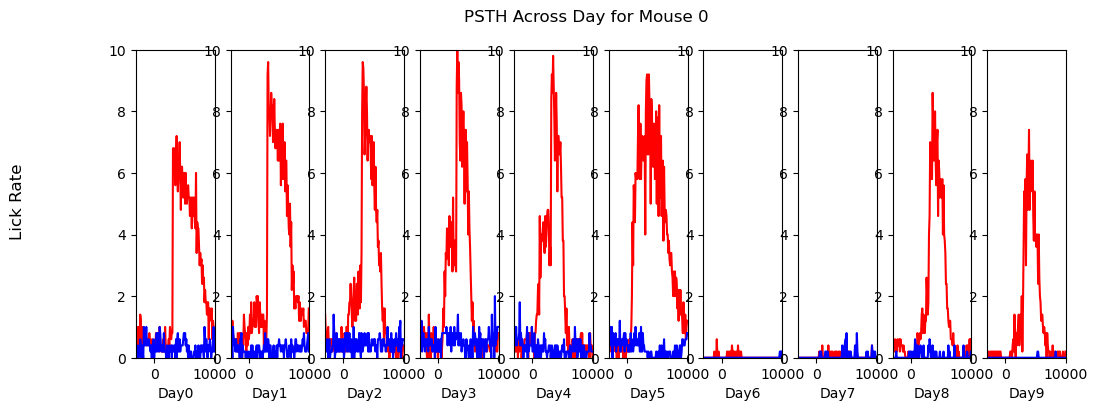

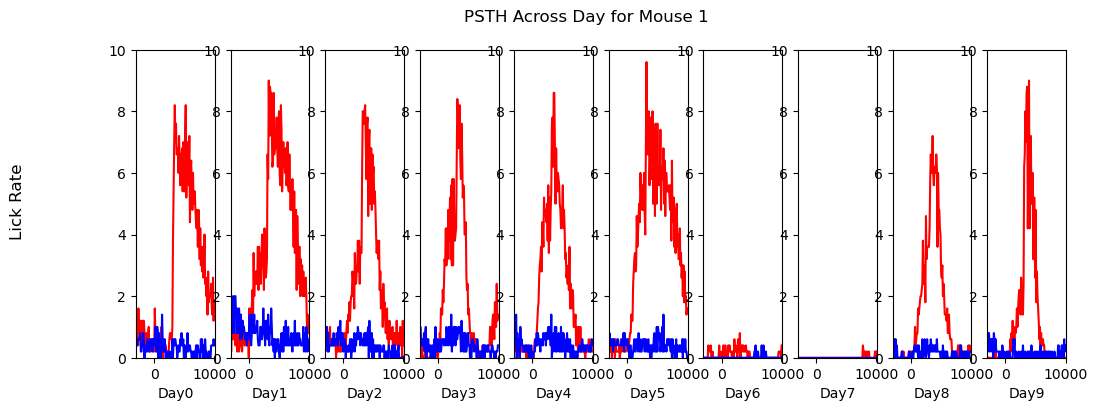

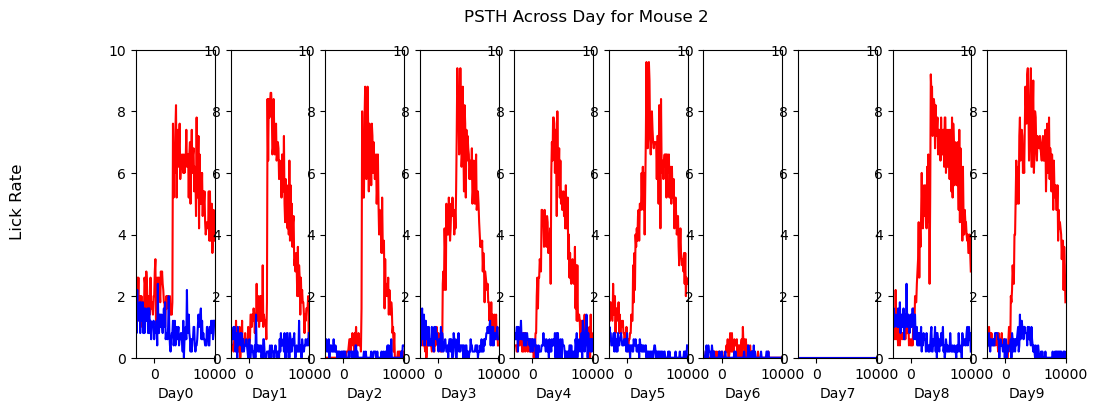

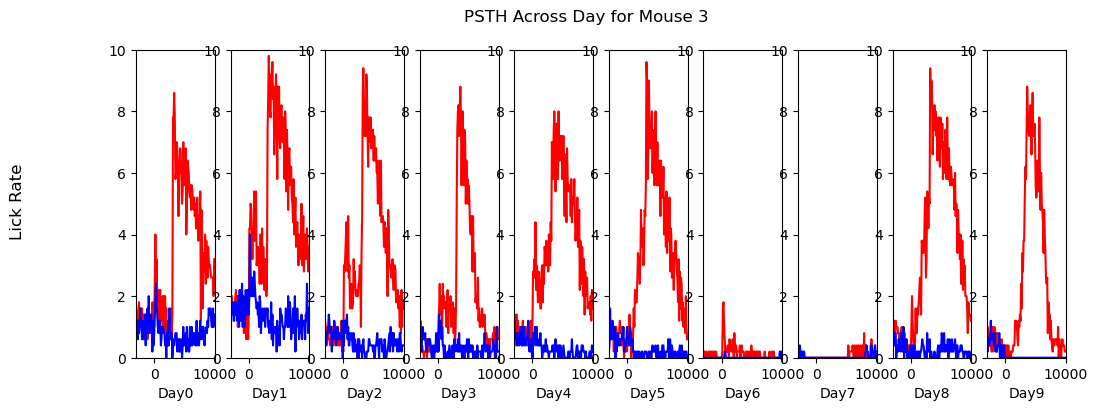

In [20]:
#CELL 6

#Plot PSTH for each Mouse 


for iM in range(np.size(mouseDataCSPlus,0)):
    fig, axs = plt.subplots(1, np.size(mouseDataCSPlus,1), figsize=(12,4))
    for iF in range(np.size(mouseDataCSPlus,1)):
        axs[iF].plot(np.transpose(np.arange(-3000,10000,100)), CSplusacrosstrials[iM,iF,:],color = "red")
        axs[iF].plot(np.transpose(np.arange(-3000,10000,100)), CSminusacrosstrials[iM,iF,:],color = "blue")
        axs[iF].set(xlabel = 'Day' + str(iF))
        plt.setp(axs, xlim = [-3000, 10000],ylim = [0, 10])
    fig.suptitle('PSTH Across Day for Mouse ' + str(iM))
    fig.supylabel("Lick Rate")


Text(0.02, 0.5, 'Lick Rate')

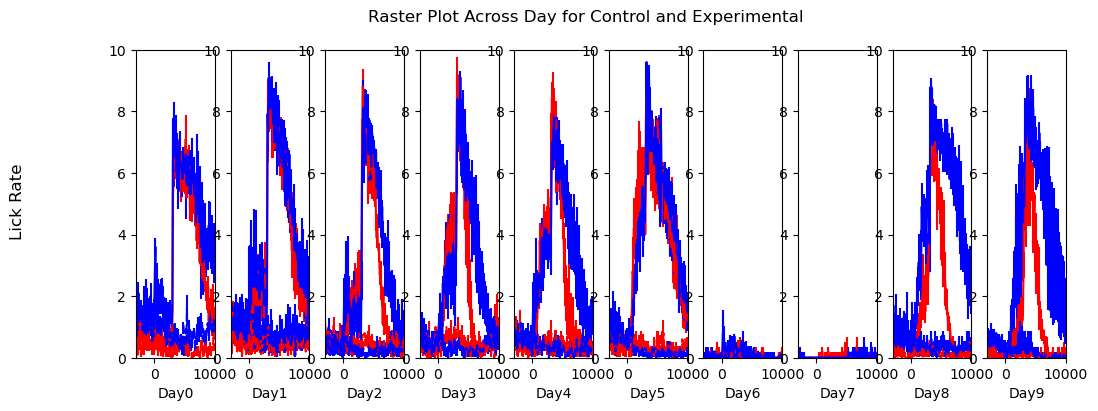

In [19]:
#Cell 7

#Plot PSTH for Control vs Experimental Animals

fig, axs = plt.subplots(1, np.size(mouseDataCSPlus,1),figsize=(12,4))
for iF in range(np.size(mouseDataCSPlus,1)):
    axs[iF].errorbar(np.transpose(np.arange(-3000,10000,100)), controlCSplusacrosstrialsavg[0,iF,:], yerr = controlCSplusacrosstrialssem[0,iF,:], color = "red", linestyle = "solid")
    axs[iF].errorbar(np.transpose(np.arange(-3000,10000,100)), controlCSminusacrosstrialsavg[0,iF,:], yerr = controlCSminusacrosstrialssem[0,iF,:], color = "red", linestyle = "dashed")
    axs[iF].errorbar(np.transpose(np.arange(-3000,10000,100)), expCSplusacrosstrialsavg[0,iF,:], yerr = expCSplusacrosstrialssem[0,iF,:], color = "blue", linestyle = "solid")
    axs[iF].errorbar(np.transpose(np.arange(-3000,10000,100)), expCSminusacrosstrialsavg[0,iF,:], yerr = expCSminusacrosstrialssem[0,iF,:], color = "blue", linestyle = "dashed")
    axs[iF].set(xlabel = 'Day' + str(iF))
    plt.setp(axs, xlim = [-3000, 10000],ylim = [0, 10])
fig.suptitle('Raster Plot Across Day for Control and Experimental')
fig.supylabel("Lick Rate")


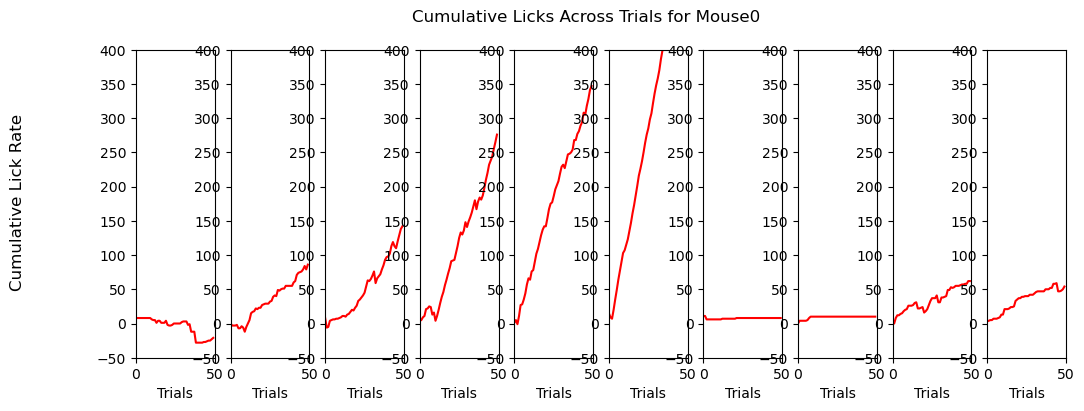

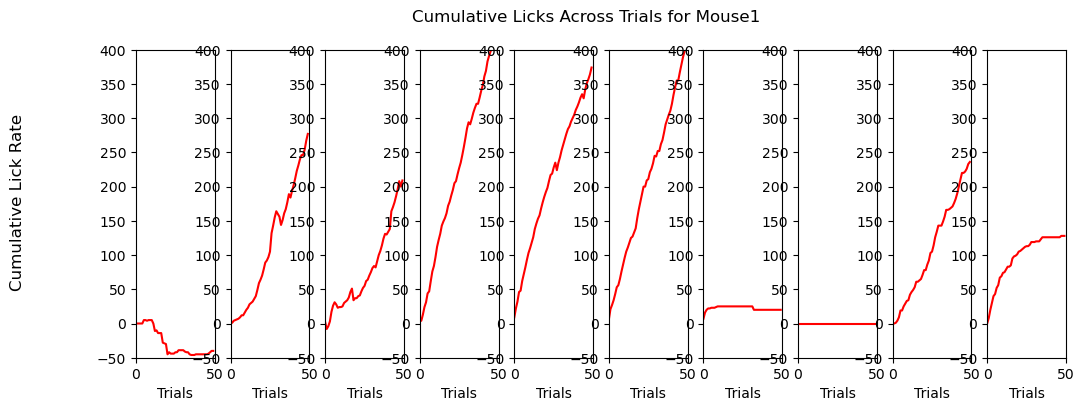

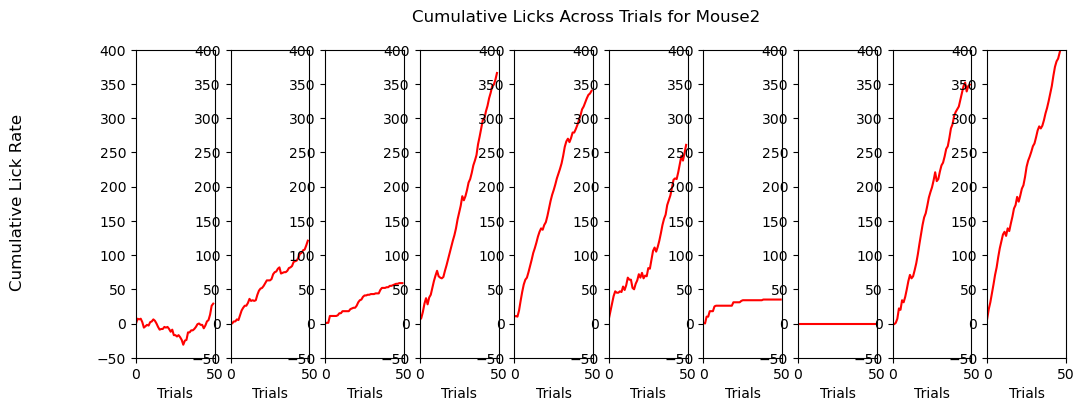

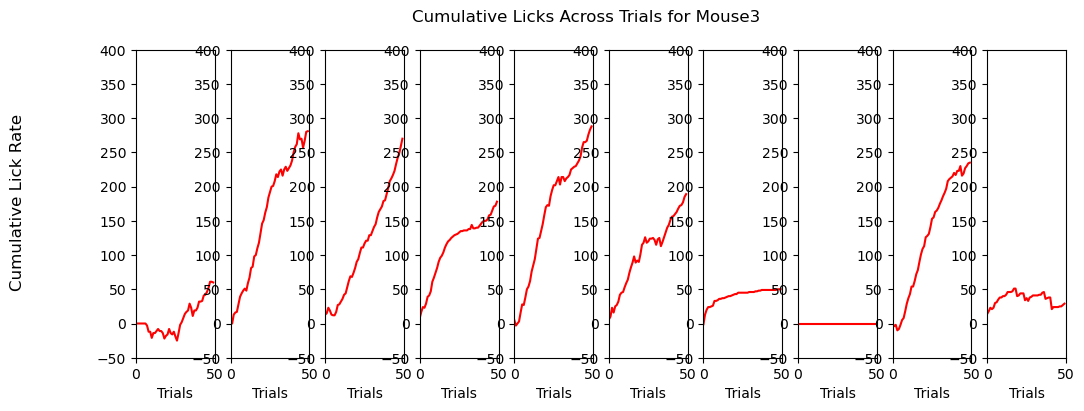

In [18]:
#Cell 8

#Plot Cumulative Lick Rate Sum Across Trials for Last Extinction Day and Two Reacquisition Days

for iM in range(np.size(mouseDataCSPlus,0)):
    fig, axs = plt.subplots(1, np.size(mouseDataCSPlus,1),figsize=(12,4))
    for iF in range(np.size(mouseDataCSPlus,1)):
        axs[iF].plot(range(np.size(CSplusbaselinesubtractedacrosstrials[iM,iF,:])), np.cumsum(CSplusbaselinesubtractedacrosstrials[iM,iF,:]), color = "red", linestyle = "solid")
        #axs[iM,iF].plot(range(np.size(CSminusbaselinesubtractedacrosstrials[iM,iF,:])), np.cumsum(CSminusbaselinesubtractedacrosstrials[iM,iF,:]), color = "blue", linestyle = "solid")
        #axs[iM,iF].plot(range(np.size(CSplusbaselinesubtractedacrosstrials[iM,iF,:])), np.cumsum(CSplusbaselinesubtractedacrosstrials[iM,iF,:]-CSminusbaselinesubtractedacrosstrials[iM,iF,:]), color = "green", linestyle = "solid")
        plt.setp(axs, xlim = [0, 50],ylim = [-50, 400])
        axs[iF].set(xlabel = 'Trials')
    fig.suptitle('Cumulative Licks Across Trials for Mouse' + str(iM))
    fig.supylabel("Cumulative Lick Rate")
        

In [3]:
def findday(file):
    """Returns the date (day in month) from a given filename.

    Args:
        file (str): Filename.

    Returns:
        If day is in filename, return numerical date. Otherwise return 0.
    """
    if 'Day' in file:
        return int(re.split('Day|_', os.path.basename(os.path.dirname(file)))[1])
    else:
        return 0


def findfiles(directory, fileformat, mousename=[], daylist=[]):
    """Find all files with fileformat under directory if daylist is specified, only find files in certain days ex)
    daylist = [3,5]: search files in directory/mousename/Day3, directory/mousename/Day5 if daylist is empty,
    search all files in directory.

    Args:
        directory (str): String with directory containing all data.
        fileformat (str list): File format being searched. ex: '.mat'
        mousename (str): Name of mouse being analyzed.
        daylist (int list): List of specific dates being analyzed.

    Returns:
        files (str list): List of files.
        days (int list): List of dates corresponding each file.
    """

    # find files
    files = [os.path.join(root, name)
             for root, dirs, files in os.walk(directory)
             for name in files if os.path.splitext(name)[-1] in fileformat]

    # if mousename is empty, just find all files with fileformat under directory. In this case you don't have list of days
    if len(mousename) > 0:
        # find date of each file
        files = [file for file in files if mousename in file.split('/')]
        files = sorted(files, key=findday)
        days = [findday(f) for f in files]
        files = [x for x, y in zip(files, days) if y > 0]
        days = [x for x in days if x > 0]
    else:
        days = None

    # remove files/days that are not in daylist
    if len(daylist) > 0:
        indaylist = [i for i, v in enumerate(days) if v in daylist]
        files = [files[i] for i in indaylist]
        days = [days[i] for i in indaylist]

    return files, days


def _check_vars(d):
    """ Checks if entries in dictionary are mat-objects. If yes, todict is called to change them to nested dictionaries"""
    #TODO(annie-taylor): update documentation
    for key in d:
        if isinstance(d[key], matlab.mio5_params.mat_struct):
            d[key] = _todict(d[key])
        elif isinstance(d[key], np.ndarray):
            d[key] = _toarray(d[key])
    return d


def _todict(matobj):
    """A recursive function which constructs from matobjects nested dictionaries"""
    #TODO(annie-taylor): update documentation
    d = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, matlab.mio5_params.mat_struct):
            d[strg] = _todict(elem)
        elif isinstance(elem, np.ndarray): \
                d[strg] = _toarray(elem)
        else:
            d[strg] = elem
    return d


def _toarray(ndarray):
    """A recursive function which constructs ndarray from cellarrays (which are loaded as numpy ndarrays), recursing
    into the elements if they contain matobjects."""
    #TODO(annie-taylor): update documentation
    if ndarray.dtype != 'float64':
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_toarray(sub_elem))
            else:
                elem_list.append(sub_elem)
        return np.array(elem_list)
    else:
        return ndarray


def load_mat(filename):
    """This function should be called instead of direct scipy.io.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects

    Args:
        filename (str): Full path of mat file.

    Returns:
        data (dictionary): Dictionary of variables in mat file.
        Key corresponds to the original variable name in mat file.
    """

    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_vars(data)
